In [1]:
import cv2, json, torch, wandb
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from ultralytics import YOLO
from utils import plot_images

In [27]:
api = wandb.Api()
# mosaic - run_zh55zy10_model:best
# no mosaic - run_g455f5ab_model:best
artifact = api.artifact("g1y5x3/fisheye-challenge/run_zh55zy10_model:best")
artifact_dir = artifact.download()
artifact_dir

wandb: Downloading large artifact run_zh55zy10_model:best, 130.59MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:3.1


'/workspace/fisheye_challenge/artifacts/run_zh55zy10_model:v0'

In [28]:
model = YOLO(f"{artifact_dir}/best.pt")

In [29]:
train_dir = "/workspace/FishEye8k/dataset/Fisheye8K_all_including_train/train/"
gt_dir = "/workspace/FishEye8k/dataset/Fisheye8K_all_including_train/train/train.json"
with open(gt_dir) as f: gts   = json.load(f)
gt_img, gt_ann = gts["images"], gts["annotations"]

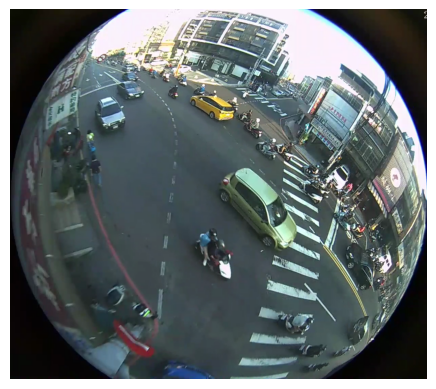

In [30]:
idx = "camera3_A_100.png"

img = Image.open(train_dir + "images/" + idx)
plt.imshow(img)
plt.axis('off') # Remove axes for cleaner display
plt.show()

## Ground Truth

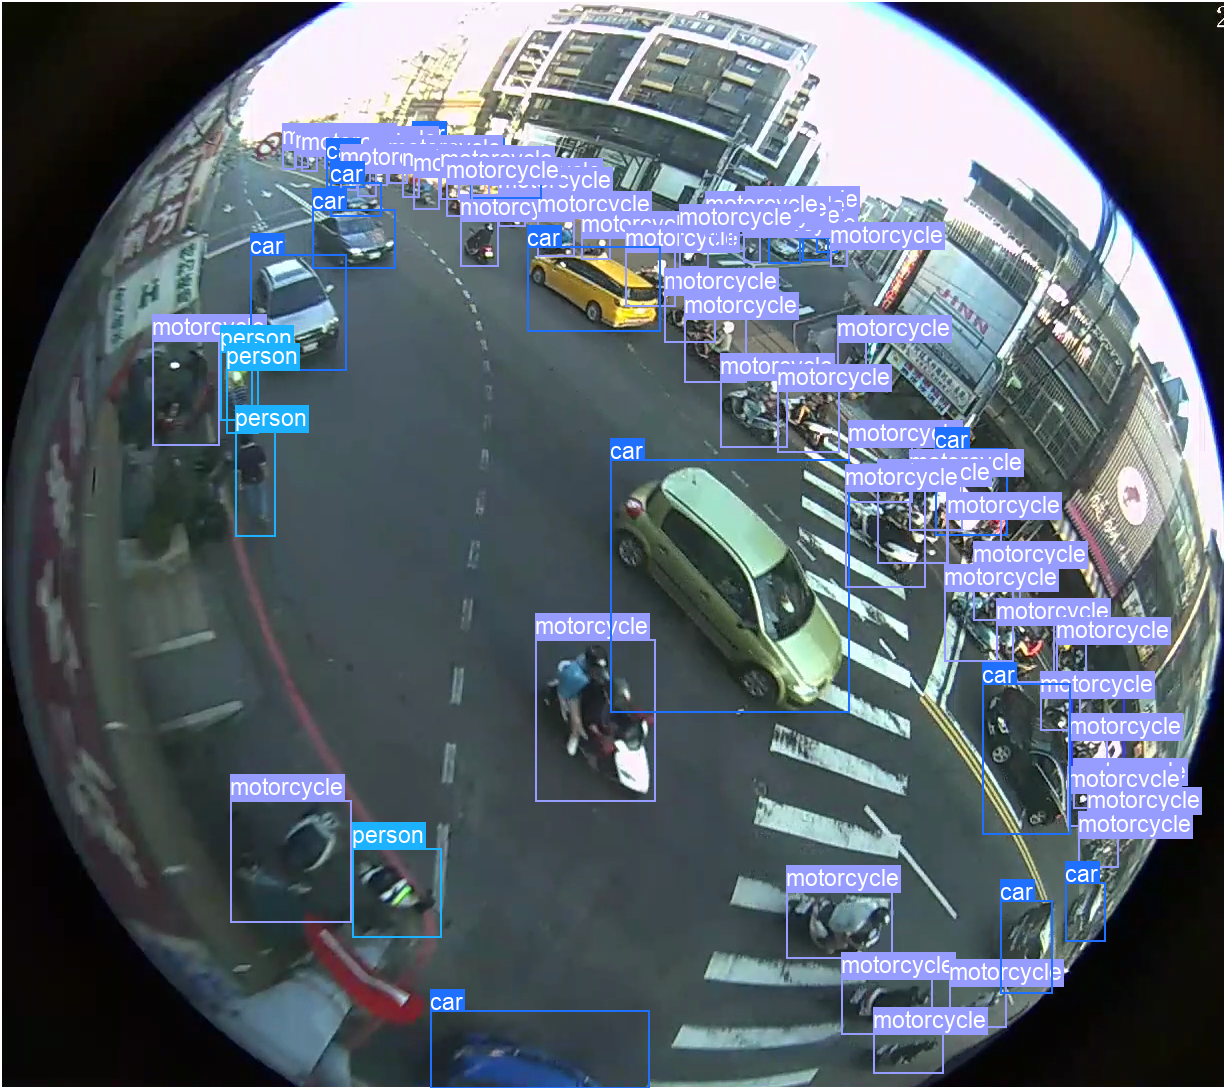

In [31]:
img = cv2.imread(train_dir + "images/" + idx)

# get ground truth
img_id = [gt["id"] for gt in gt_img if gt["file_name"] == idx]
bboxes = np.array([gt["bbox"] for gt in gt_ann if gt["image_id"] == img_id[0]])
cls = np.array([gt["category_id"] for gt in gt_ann if gt["image_id"] == img_id[0]])
names = {0: 'bus', 1: 'motorcycle', 2: 'car', 3: 'person', 4: 'truck'}

img_gt = plot_images(img, cls, bboxes, None, names, plot=True)

In [32]:
img_new = np.concatenate((img[544:,:,:], img[:544,:,:]), axis=0)
img_new.shape

(1088, 1225, 3)

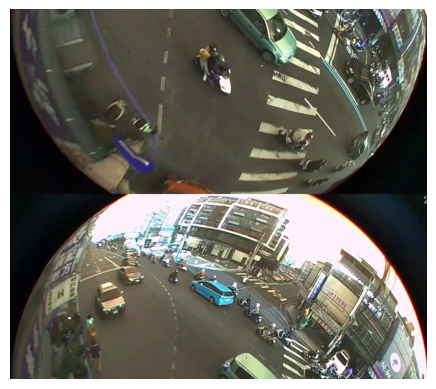

In [33]:
plt.imshow(img_new)
plt.axis('off') # Remove axes for cleaner display
plt.show()

In [34]:
results = model.predict(img, project="fisheye", name="dcn_results", imgsz=1280, visualize=False, show_labels=False, show_conf=False)


(1088, 1225, 3)
torch.Size([1, 3, 1152, 1280])
0: 1152x1280 1 bus, 53 bikes, 16 cars, 4 pedestrians, 26.5ms
Speed: 4.9ms preprocess, 26.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1152, 1280)


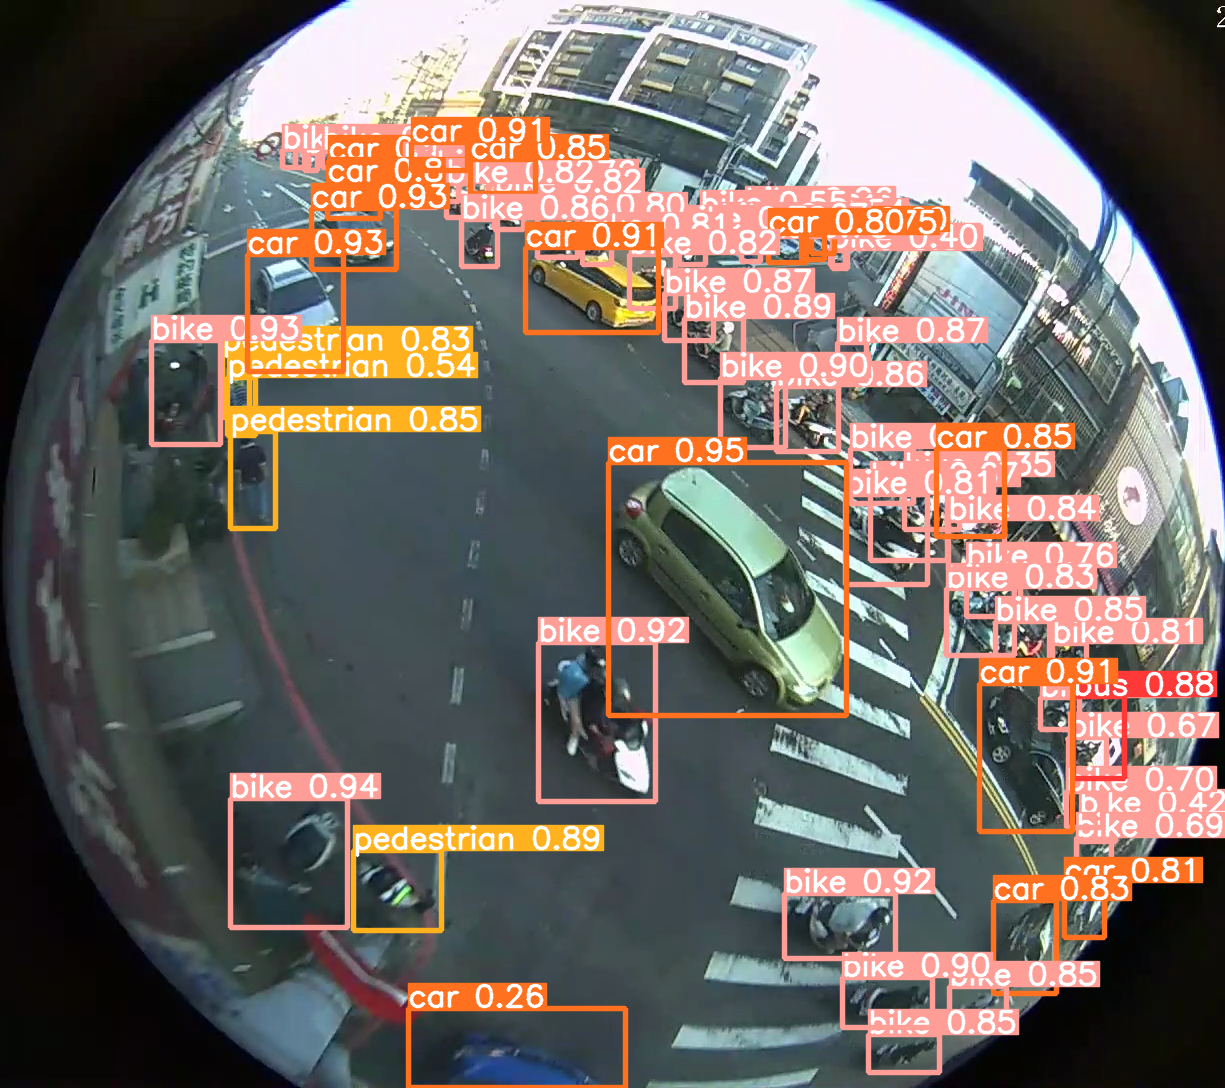

In [35]:
results[0].show()

## Inspect the receptive field of the model

In [ ]:
%matplotlib inline
img = Image.open("fisheye/dcn_results2/image0/stage1_DeformableConv_features.png")
plt.figure(figsize=(26,10))
plt.imshow(img)
plt.axis('off') # Remove axes for cleaner display
plt.show()

In [ ]:
%matplotlib inline
img = Image.open("fisheye/results/image0/stage15_C2f_features.png")
plt.figure(figsize=(26,10))
plt.imshow(img)
plt.axis('off') # Remove axes for cleaner display
plt.show()

In [ ]:
%matplotlib inline
img = Image.open("fisheye/results/image0/stage18_C2f_features.png")
plt.figure(figsize=(26,10))
plt.imshow(img)
plt.axis('off') # Remove axes for cleaner display
plt.show()

In [ ]:
%matplotlib inline
img = Image.open("fisheye/results/image0/stage21_C2f_features.png")
plt.figure(figsize=(26,10))
plt.imshow(img)
plt.axis('off') # Remove axes for cleaner display
plt.show()

## Inspect Offsets

In [ ]:
from ultralytics.utils import DEFAULT_CFG, LOGGER, MACOS, WINDOWS, callbacks, colorstr, ops

In [36]:
model.model

DetectionModel(
  (model): Sequential(
    (0): DeformableConv(
      (conv): Conv2d(3, 80, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (offset_conv): Conv2d(3, 18, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (mask_conv): Conv2d(3, 9, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (1): DeformableConv(
      (conv): Conv2d(80, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (offset_conv): Conv2d(80, 18, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (mask_conv): Conv2d(80, 9, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(160, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (2): C2f(
      (cv1): Conv(
        (conv): Conv2d(160, 160, kernel_siz

In [37]:
model.model.model[0].offset_conv

Conv2d(3, 18, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)

In [38]:
print(img.shape)
model.predictor.setup_source(img)
img2 = img[np.newaxis, :, :]
img3 = model.predictor.preprocess(img2)
print(img3.shape)

(1088, 1225, 3)
torch.Size([1, 3, 1152, 1280])


In [39]:
model.model.model[0].conv

Conv2d(3, 80, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)

In [40]:
offsets1 = model.model.model[0].offset_conv(img3)
print(offsets1.shape)
offsets1

torch.Size([1, 18, 576, 640])


tensor([[[[-0.0032, -0.0043, -0.0043,  ..., -0.0043, -0.0043, -0.0043],
          [-0.0029, -0.0042, -0.0042,  ..., -0.0042, -0.0042, -0.0042],
          [-0.0029, -0.0042, -0.0042,  ..., -0.0042, -0.0042, -0.0042],
          ...,
          [-0.0029, -0.0042, -0.0042,  ..., -0.0042, -0.0042, -0.0042],
          [-0.0029, -0.0042, -0.0042,  ..., -0.0042, -0.0042, -0.0042],
          [-0.0029, -0.0042, -0.0042,  ..., -0.0042, -0.0042, -0.0042]],

         [[ 0.0097,  0.0150,  0.0150,  ...,  0.0150,  0.0150,  0.0150],
          [ 0.0159,  0.0262,  0.0262,  ...,  0.0262,  0.0262,  0.0262],
          [ 0.0159,  0.0262,  0.0262,  ...,  0.0262,  0.0262,  0.0262],
          ...,
          [ 0.0159,  0.0262,  0.0262,  ...,  0.0262,  0.0262,  0.0262],
          [ 0.0159,  0.0262,  0.0262,  ...,  0.0262,  0.0262,  0.0262],
          [ 0.0159,  0.0262,  0.0262,  ...,  0.0262,  0.0262,  0.0262]],

         [[ 0.0131,  0.0197,  0.0197,  ...,  0.0197,  0.0197,  0.0197],
          [ 0.0229,  0.0343,  

In [ ]:
h, w = preprocessed.shape[2:]
max_offset = max(h, w)/4.
max_offset
# model.model.model[0].offset_conv